<a href="https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/SegFormer/Fine_tune_SegFormer_on_custom_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Fine-tune SegFormer on a custom dataset

In this notebook, we are going to fine-tune [SegFormerForSemanticSegmentation](https://huggingface.co/docs/transformers/main/model_doc/segformer#transformers.SegformerForSemanticSegmentation) on a custom **semantic segmentation** dataset. In semantic segmentation, the goal for the model is to label each pixel of an image with one of a list of predefined classes.

We load the encoder of the model with weights pre-trained on ImageNet-1k, and fine-tune it together with the decoder head, which starts with randomly initialized weights.

In [25]:
!pip install -q transformers datasets evaluate

## Download toy dataset

Here we download a small subset of the ADE20k dataset, which is an important benchmark for semantic segmentation. It contains 150 labels.

I've made a small subset just for demonstration purposes (namely the 10 first training and 10 first validation images + segmentation maps). The goal for the model is to overfit this tiny dataset (because that makes sure that it'll work on a larger scale).

In [1]:
import requests, zipfile, io

def download_data():
    url = "https://www.dropbox.com/s/l1e45oht447053f/ADE20k_toy_dataset.zip?dl=1"
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall()

download_data()

Note that this dataset is now also available on the hub :) you can directly check out the images [in your browser](scene_parse_150)! It can be easily loaded as follows (note that loading will take some time as the dataset is several GB's large):

In [2]:
from datasets import load_dataset

load_entire_dataset = False

if load_entire_dataset:
  dataset = load_dataset("scene_parse_150")

## Define PyTorch dataset and dataloaders

Here we define a [custom PyTorch dataset](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html). Each item of the dataset consists of an image and a corresponding segmentation map.

In [3]:
from torch.utils.data import Dataset
import os
from PIL import Image

class SemanticSegmentationDataset(Dataset):
    """Image (semantic) segmentation dataset."""

    def __init__(self, root_dir, image_processor, train=True):
        """
        Args:
            root_dir (string): Root directory of the dataset containing the images + annotations.
            image_processor (SegFormerImageProcessor): image processor to prepare images + segmentation maps.
            train (bool): Whether to load "training" or "validation" images + annotations.
        """
        self.root_dir = root_dir
        self.image_processor = image_processor
        self.train = train

        sub_path = "training" if self.train else "validation"
        self.img_dir = os.path.join(self.root_dir, "images", sub_path)
        self.ann_dir = os.path.join(self.root_dir, "annotations", sub_path)

        # read images
        image_file_names = []
        for root, dirs, files in os.walk(self.img_dir):
          image_file_names.extend(files)
        self.images = sorted(image_file_names)

        # read annotations
        annotation_file_names = []
        for root, dirs, files in os.walk(self.ann_dir):
          annotation_file_names.extend(files)
        self.annotations = sorted(annotation_file_names)

        assert len(self.images) == len(self.annotations), "There must be as many images as there are segmentation maps"

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):

        image = Image.open(os.path.join(self.img_dir, self.images[idx]))
        segmentation_map = Image.open(os.path.join(self.ann_dir, self.annotations[idx]))

        # randomly crop + pad both image and segmentation map to same size
        encoded_inputs = self.image_processor(image, segmentation_map, return_tensors="pt")

        for k,v in encoded_inputs.items():
          encoded_inputs[k].squeeze_() # remove batch dimension

        return encoded_inputs

Let's initialize the training + validation datasets. Important: we initialize the image processor with `reduce_labels=True`, as the classes in ADE20k go from 0 to 150, with 0 meaning "background". However, we want the labels to go from 0 to 149, and only train the model to recognize the 150 classes (which don't include "background"). Hence, we'll reduce all labels by 1 and replace 0 by 255, which is the `ignore_index` of SegFormer's loss function.

In [6]:
from transformers import SegformerImageProcessor

root_dir = 'ADE20k_toy_dataset'
image_processor = SegformerImageProcessor(reduce_labels=True)

train_dataset = SemanticSegmentationDataset(root_dir=root_dir, image_processor=image_processor)
valid_dataset = SemanticSegmentationDataset(root_dir=root_dir, image_processor=image_processor, train=False)

In [ ]:
train_dataset[0].keys() # check that the dataset is loaded correctly

dict_keys(['pixel_values', 'labels'])

In [30]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(valid_dataset))

Number of training examples: 10
Number of validation examples: 10


Let's verify a random example:

In [31]:
encoded_inputs = train_dataset[0]

In [32]:
encoded_inputs["pixel_values"].shape

torch.Size([3, 512, 512])

In [33]:
encoded_inputs["labels"].shape

torch.Size([512, 512])

In [34]:
encoded_inputs["labels"]

tensor([[255, 255, 255,  ...,   5,   5,   5],
        [255,   5,   5,  ...,   5,   5,   5],
        [255,   5,   5,  ...,   5,   5,   5],
        ...,
        [  3,   3,   3,  ...,   0,   0, 255],
        [  3,   3,   3,  ...,   0,   0, 255],
        [  3,   3,   3,  ...,   0,   0,   0]])

In [35]:
encoded_inputs["labels"].squeeze().unique()

tensor([  0,   3,   4,   5,  12,  17,  31,  32,  42,  43,  87,  96, 104, 125,
        138, 149, 255])

Next, we define corresponding dataloaders.

In [36]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=2)

In [37]:
batch = next(iter(train_dataloader))

In [38]:
for k,v in batch.items():
  print(k, v.shape)

pixel_values torch.Size([2, 3, 512, 512])
labels torch.Size([2, 512, 512])


In [39]:
batch["labels"].shape

torch.Size([2, 512, 512])

In [40]:
mask = (batch["labels"] != 255)
mask

tensor([[[ True,  True,  True,  ...,  True,  True, False],
         [ True,  True,  True,  ...,  True,  True, False],
         [ True,  True,  True,  ...,  True,  True, False],
         ...,
         [ True,  True,  True,  ...,  True,  True, False],
         [ True,  True,  True,  ...,  True,  True, False],
         [False, False, False,  ...,  True,  True, False]],

        [[False, False, False,  ...,  True,  True, False],
         [False,  True,  True,  ...,  True,  True, False],
         [False,  True,  True,  ...,  True,  True, False],
         ...,
         [False,  True,  True,  ...,  True,  True, False],
         [False,  True,  True,  ...,  True,  True, False],
         [False, False, False,  ..., False, False, False]]])

In [41]:
batch["labels"][mask]

tensor([0, 0, 0,  ..., 3, 3, 3])

## Define the model

Here we load the model, and equip the encoder with weights pre-trained on ImageNet-1k (we take the smallest variant, `nvidia/mit-b0` here, but you can take a bigger one like `nvidia/mit-b5` from the [hub](https://huggingface.co/models?other=segformer)). We also set the `id2label` and `label2id` mappings, which will be useful when performing inference.

In [42]:
from transformers import SegformerForSemanticSegmentation
import json
from huggingface_hub import hf_hub_download

# load id2label mapping from a JSON on the hub
repo_id = "huggingface/label-files"
filename = "ade20k-id2label.json"
id2label = json.load(open(hf_hub_download(repo_id=repo_id, filename=filename, repo_type="dataset"), "r"))
id2label = {int(k): v for k, v in id2label.items()}
label2id = {v: k for k, v in id2label.items()}

# define model
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b0",
                                                         num_labels=150,
                                                         id2label=id2label,
                                                         label2id=label2id,
)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.weight', 'decode_head.linear_fuse.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.classifier.bias', 'decode_head.batch_norm.running_var', 'decode_head.linear_c.0.proj.weight', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.linear_c.3.proj.weight', 'decode_head.batch_norm.bias', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.classifier.weight', 'decode_head.linear_c.3.proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Fine-tune the model

Here we fine-tune the model in native PyTorch, using the AdamW optimizer. We use the same learning rate as the one reported in the [paper](https://arxiv.org/abs/2105.15203).

It's also very useful to track metrics during training. For semantic segmentation, typical metrics include the mean intersection-over-union (mIoU) and pixel-wise accuracy. These are available in the Datasets library. We can load it as follows:

In [43]:
import evaluate

metric = evaluate.load("mean_iou")

In [49]:
image_processor.do_reduce_labels

True

In [50]:
import torch
from torch import nn
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm

# define optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006)
# move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.train()
for epoch in range(200):  # loop over the dataset multiple times
   print("Epoch:", epoch)
   for idx, batch in enumerate(tqdm(train_dataloader)):
        # get the inputs;
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(pixel_values=pixel_values, labels=labels)
        loss, logits = outputs.loss, outputs.logits

        loss.backward()
        optimizer.step()

        # evaluate
        with torch.no_grad():
          upsampled_logits = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
          predicted = upsampled_logits.argmax(dim=1)

          # note that the metric expects predictions + labels as numpy arrays
          metric.add_batch(predictions=predicted.detach().cpu().numpy(), references=labels.detach().cpu().numpy())

        # let's print loss and metrics every 100 batches
        if idx % 100 == 0:
          # currently using _compute instead of compute
          # see this issue for more info: https://github.com/huggingface/evaluate/pull/328#issuecomment-1286866576
          metrics = metric._compute(
                  predictions=predicted.cpu(),
                  references=labels.cpu(),
                  num_labels=len(id2label),
                  ignore_index=255,
                  reduce_labels=False, # we've already reduced the labels ourselves
              )

          print("Loss:", loss.item())
          print("Mean_iou:", metrics["mean_iou"])
          print("Mean accuracy:", metrics["mean_accuracy"])

Epoch: 0


  0%|          | 0/5 [00:00<?, ?it/s]

/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


Loss: 2.4901068210601807
Mean_iou: 0.19833479132640147
Mean accuracy: 0.3272488162004094
Epoch: 1


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.6605288982391357
Mean_iou: 0.20337142317732576
Mean accuracy: 0.38642028803579975
Epoch: 2


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.7926678657531738
Mean_iou: 0.29023908362797396
Mean accuracy: 0.4730168171748427
Epoch: 3


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.674771785736084
Mean_iou: 0.29009107606785833
Mean accuracy: 0.4668393361144211
Epoch: 4


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.4283632040023804
Mean_iou: 0.33365786241019296
Mean accuracy: 0.6059888922729484
Epoch: 5


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.1924383640289307
Mean_iou: 0.14258934337308063
Mean accuracy: 0.21963379897933633
Epoch: 6


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.3574631214141846
Mean_iou: 0.1782374917900235
Mean accuracy: 0.29966148568599305
Epoch: 7


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.9852250814437866
Mean_iou: 0.3051692165242882
Mean accuracy: 0.39873960396118996
Epoch: 8


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.362901449203491
Mean_iou: 0.14973313943131064
Mean accuracy: 0.2378025754685566
Epoch: 9


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.9165492057800293
Mean_iou: 0.316522208377792
Mean accuracy: 0.5336981220697867
Epoch: 10


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.1685950756073
Mean_iou: 0.25109055399280483
Mean accuracy: 0.3777094356007436
Epoch: 11


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.120368480682373
Mean_iou: 0.15807873356939528
Mean accuracy: 0.20860743548486152
Epoch: 12


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8269525170326233
Mean_iou: 0.42972253818673223
Mean accuracy: 0.6108288801292968
Epoch: 13


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.767127513885498
Mean_iou: 0.4083446904789611
Mean accuracy: 0.5031021418602124
Epoch: 14


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.9321986436843872
Mean_iou: 0.5102438054832585
Mean accuracy: 0.7048530496639743
Epoch: 15


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.3630491495132446
Mean_iou: 0.2122065568774032
Mean accuracy: 0.29956048642532973
Epoch: 16


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.3828959465026855
Mean_iou: 0.39617031300300304
Mean accuracy: 0.49611054502148777
Epoch: 17


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.511244297027588
Mean_iou: 0.1442075719709278
Mean accuracy: 0.2030809390354066
Epoch: 18


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0441083908081055
Mean_iou: 0.34695108377950207
Mean accuracy: 0.5094358401080785
Epoch: 19


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.2817015647888184
Mean_iou: 0.42840827833076417
Mean accuracy: 0.5864426499336558
Epoch: 20


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.8650975227355957
Mean_iou: 0.1713703539299463
Mean accuracy: 0.22548876714845387
Epoch: 21


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.225362539291382
Mean_iou: 0.24357248478338775
Mean accuracy: 0.33816238397860404
Epoch: 22


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.1159461736679077
Mean_iou: 0.4176467578549543
Mean accuracy: 0.5465983508989037
Epoch: 23


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.4178544282913208
Mean_iou: 0.25136745689654155
Mean accuracy: 0.32902927541568394
Epoch: 24


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8285512924194336
Mean_iou: 0.5059321195397616
Mean accuracy: 0.7565876602361132
Epoch: 25


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.5946274995803833
Mean_iou: 0.404387425242223
Mean accuracy: 0.549200176549021
Epoch: 26


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.2709912061691284
Mean_iou: 0.51609295461641
Mean accuracy: 0.7299088740359768
Epoch: 27


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.4455580711364746
Mean_iou: 0.5168339096436573
Mean accuracy: 0.7576396463775398
Epoch: 28


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.2187625169754028
Mean_iou: 0.15529388218502369
Mean accuracy: 0.21190344923588308
Epoch: 29


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.2444114685058594
Mean_iou: 0.41863884459310613
Mean accuracy: 0.5011636015684285
Epoch: 30


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.525977373123169
Mean_iou: 0.36928699137908483
Mean accuracy: 0.47171468397129107
Epoch: 31


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.7448619604110718
Mean_iou: 0.22163284369490657
Mean accuracy: 0.3088457724551227
Epoch: 32


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.6708598136901855
Mean_iou: 0.3535490987009382
Mean accuracy: 0.5177182138026851
Epoch: 33


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.141627550125122
Mean_iou: 0.5628857677733701
Mean accuracy: 0.7336899331130649
Epoch: 34


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.4829617738723755
Mean_iou: 0.3271018744357719
Mean accuracy: 0.43661785188381586
Epoch: 35


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0755404233932495
Mean_iou: 0.24575429204525423
Mean accuracy: 0.34766198798707
Epoch: 36


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0075242519378662
Mean_iou: 0.3005609269304069
Mean accuracy: 0.3945910815555873
Epoch: 37


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.1786575317382812
Mean_iou: 0.2299543778470527
Mean accuracy: 0.33531027331130503
Epoch: 38


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5399602055549622
Mean_iou: 0.6208531716855445
Mean accuracy: 0.803696049824611
Epoch: 39


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.4479018449783325
Mean_iou: 0.3260968520571604
Mean accuracy: 0.4007205786929984
Epoch: 40


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.046026349067688
Mean_iou: 0.5226431396319051
Mean accuracy: 0.7581079298113198
Epoch: 41


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.971183180809021
Mean_iou: 0.25375238319317844
Mean accuracy: 0.31389247837632783
Epoch: 42


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.650156557559967
Mean_iou: 0.498063106240779
Mean accuracy: 0.7481267410493309
Epoch: 43


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0154690742492676
Mean_iou: 0.2517818890528084
Mean accuracy: 0.30990384371580176
Epoch: 44


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0195331573486328
Mean_iou: 0.12810026090764576
Mean accuracy: 0.19316874510201557
Epoch: 45


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7592940926551819
Mean_iou: 0.4522614322657394
Mean accuracy: 0.5451526650183938
Epoch: 46


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.1923911571502686
Mean_iou: 0.1476707703433656
Mean accuracy: 0.2246499965913785
Epoch: 47


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0386751890182495
Mean_iou: 0.19420602730314088
Mean accuracy: 0.3244706490383588
Epoch: 48


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0265341997146606
Mean_iou: 0.632642793873816
Mean accuracy: 0.6672830927562468
Epoch: 49


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6365061402320862
Mean_iou: 0.4353295925764742
Mean accuracy: 0.623313620569096
Epoch: 50


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.197509765625
Mean_iou: 0.1828208401967225
Mean accuracy: 0.26697994333251185
Epoch: 51


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3431377112865448
Mean_iou: 0.43829610250123885
Mean accuracy: 0.6201829494998141
Epoch: 52


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9768912196159363
Mean_iou: 0.26712907557936993
Mean accuracy: 0.36758537157039745
Epoch: 53


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9969302415847778
Mean_iou: 0.5754198952436541
Mean accuracy: 0.6478432121477492
Epoch: 54


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.069570779800415
Mean_iou: 0.5510964138835344
Mean accuracy: 0.6600372466311485
Epoch: 55


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.47490638494491577
Mean_iou: 0.723054749626919
Mean accuracy: 0.8576529668422723
Epoch: 56


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.856100857257843
Mean_iou: 0.4442034821823585
Mean accuracy: 0.5045501705768426
Epoch: 57


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.155995488166809
Mean_iou: 0.20569832239100258
Mean accuracy: 0.26366150495089896
Epoch: 58


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7546881437301636
Mean_iou: 0.16868032827136878
Mean accuracy: 0.24061874521636542
Epoch: 59


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.24140304327011108
Mean_iou: 0.3745852557630781
Mean accuracy: 0.622900320369633
Epoch: 60


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5276841521263123
Mean_iou: 0.414811290891288
Mean accuracy: 0.5338154741288526
Epoch: 61


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9281193017959595
Mean_iou: 0.3419484466824204
Mean accuracy: 0.4585779105621933
Epoch: 62


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7955940961837769
Mean_iou: 0.37734792415719826
Mean accuracy: 0.5030662487923149
Epoch: 63


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0453441143035889
Mean_iou: 0.31388494716887927
Mean accuracy: 0.3580819971553212
Epoch: 64


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7665138244628906
Mean_iou: 0.5054434981124817
Mean accuracy: 0.58454046970414
Epoch: 65


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6138264536857605
Mean_iou: 0.6261221680390539
Mean accuracy: 0.8099770360920403
Epoch: 66


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.38742658495903015
Mean_iou: 0.671283949890006
Mean accuracy: 0.7763501719631168
Epoch: 67


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7311579585075378
Mean_iou: 0.2507534145216112
Mean accuracy: 0.37775854343909154
Epoch: 68


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9620360732078552
Mean_iou: 0.31426851758117685
Mean accuracy: 0.37190079025790074
Epoch: 69


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8192299008369446
Mean_iou: 0.4687869452849461
Mean accuracy: 0.5734290266400558
Epoch: 70


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2558724582195282
Mean_iou: 0.4040720089656258
Mean accuracy: 0.6195298762141481
Epoch: 71


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6255157589912415
Mean_iou: 0.730757741643854
Mean accuracy: 0.8526779303502694
Epoch: 72


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8096837997436523
Mean_iou: 0.35737763917600396
Mean accuracy: 0.4696427563742973
Epoch: 73


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.82145756483078
Mean_iou: 0.33434284095677674
Mean accuracy: 0.45321498897138307
Epoch: 74


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.24745000898838043
Mean_iou: 0.8257449035339148
Mean accuracy: 0.8632009428558004
Epoch: 75


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6120837926864624
Mean_iou: 0.29631237823696543
Mean accuracy: 0.3853702797869162
Epoch: 76


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6038438677787781
Mean_iou: 0.3148645123727965
Mean accuracy: 0.39336894535440126
Epoch: 77


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7970967888832092
Mean_iou: 0.3134845535313413
Mean accuracy: 0.4011008953903817
Epoch: 78


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6128543615341187
Mean_iou: 0.7362030108697365
Mean accuracy: 0.8586371583968886
Epoch: 79


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6280869841575623
Mean_iou: 0.60042302979498
Mean accuracy: 0.6737050608646787
Epoch: 80


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.39958077669143677
Mean_iou: 0.4307623835750133
Mean accuracy: 0.5476855521931268
Epoch: 81


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7254643440246582
Mean_iou: 0.6205054953695439
Mean accuracy: 0.6724986649134913
Epoch: 82


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7455133199691772
Mean_iou: 0.5887886240152626
Mean accuracy: 0.7068179194405861
Epoch: 83


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5473701357841492
Mean_iou: 0.6336905203636899
Mean accuracy: 0.8722311535490768
Epoch: 84


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.574636697769165
Mean_iou: 0.42624448622056677
Mean accuracy: 0.5251584166223064
Epoch: 85


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.647889256477356
Mean_iou: 0.4100196186292262
Mean accuracy: 0.5019663559144077
Epoch: 86


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5570114254951477
Mean_iou: 0.17492285624189435
Mean accuracy: 0.2860379317346226
Epoch: 87


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6674260497093201
Mean_iou: 0.6893886577697508
Mean accuracy: 0.9380222971524615
Epoch: 88


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9918072819709778
Mean_iou: 0.28519852312209926
Mean accuracy: 0.40954738221121334
Epoch: 89


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8483073711395264
Mean_iou: 0.39204480321609736
Mean accuracy: 0.4594587832094581
Epoch: 90


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5655941367149353
Mean_iou: 0.50173742080902
Mean accuracy: 0.561555769027528
Epoch: 91


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3760134279727936
Mean_iou: 0.44303317664399133
Mean accuracy: 0.5635290930664855
Epoch: 92


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4797441363334656
Mean_iou: 0.3758688530517355
Mean accuracy: 0.5332736381294025
Epoch: 93


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2983548939228058
Mean_iou: 0.5003770152420555
Mean accuracy: 0.640320381465836
Epoch: 94


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5103418231010437
Mean_iou: 0.399077302006299
Mean accuracy: 0.4633230900762327
Epoch: 95


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5104861259460449
Mean_iou: 0.6256316758174129
Mean accuracy: 0.6631012020198827
Epoch: 96


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6562439203262329
Mean_iou: 0.22500909267085725
Mean accuracy: 0.3411550795800689
Epoch: 97


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.511228621006012
Mean_iou: 0.19704880316145124
Mean accuracy: 0.30513205971540824
Epoch: 98


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.20713520050048828
Mean_iou: 0.8338360733988892
Mean accuracy: 0.8507587907562341
Epoch: 99


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5947220921516418
Mean_iou: 0.6295036276536666
Mean accuracy: 0.7207939002422786
Epoch: 100


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.49272698163986206
Mean_iou: 0.6177028689966064
Mean accuracy: 0.6569822817456021
Epoch: 101


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5037841200828552
Mean_iou: 0.29934084279650247
Mean accuracy: 0.35889287228629096
Epoch: 102


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5384854674339294
Mean_iou: 0.6501098035274685
Mean accuracy: 0.6796407958571619
Epoch: 103


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4637385606765747
Mean_iou: 0.38843518527494636
Mean accuracy: 0.47632866976303656
Epoch: 104


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5289007425308228
Mean_iou: 0.5531073755687904
Mean accuracy: 0.6303119057676803
Epoch: 105


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.40837526321411133
Mean_iou: 0.8306418401392157
Mean accuracy: 0.876837989849409
Epoch: 106


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6787815690040588
Mean_iou: 0.414643518201855
Mean accuracy: 0.4809376006161477
Epoch: 107


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5413252115249634
Mean_iou: 0.2978010182856166
Mean accuracy: 0.3547523825628707
Epoch: 108


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7102389335632324
Mean_iou: 0.3289786697782871
Mean accuracy: 0.37026265828285965
Epoch: 109


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.43563342094421387
Mean_iou: 0.710374455246685
Mean accuracy: 0.7529327831322673
Epoch: 110


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.46511155366897583
Mean_iou: 0.2139138573477277
Mean accuracy: 0.3017383876343539
Epoch: 111


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5694959759712219
Mean_iou: 0.482834183628069
Mean accuracy: 0.5544104613427394
Epoch: 112


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6074429154396057
Mean_iou: 0.5460055030063447
Mean accuracy: 0.6747515613952068
Epoch: 113


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4689953923225403
Mean_iou: 0.6987785586254606
Mean accuracy: 0.7319401251698456
Epoch: 114


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3078814446926117
Mean_iou: 0.8332362591700959
Mean accuracy: 0.8754217341661348
Epoch: 115


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4355318546295166
Mean_iou: 0.645043827062885
Mean accuracy: 0.6750336450488452
Epoch: 116


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.141922265291214
Mean_iou: 0.9403033470240745
Mean accuracy: 0.9603068470061412
Epoch: 117


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3298860490322113
Mean_iou: 0.6360265487893997
Mean accuracy: 0.6671689177725042
Epoch: 118


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6663698554039001
Mean_iou: 0.2718016128143604
Mean accuracy: 0.3304241896603704
Epoch: 119


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5031431317329407
Mean_iou: 0.36115504747462446
Mean accuracy: 0.4462242780425366
Epoch: 120


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4177248477935791
Mean_iou: 0.8269184555708122
Mean accuracy: 0.8635288121477049
Epoch: 121


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3840813934803009
Mean_iou: 0.4338162556010941
Mean accuracy: 0.5236637032300545
Epoch: 122


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.28373995423316956
Mean_iou: 0.5553546998385223
Mean accuracy: 0.6986928969294567
Epoch: 123


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.28888562321662903
Mean_iou: 0.8356995723241943
Mean accuracy: 0.8746802957976741
Epoch: 124


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.22285550832748413
Mean_iou: 0.4930700378571751
Mean accuracy: 0.7660556081985758
Epoch: 125


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4662153720855713
Mean_iou: 0.4273747026290133
Mean accuracy: 0.5404908330911061
Epoch: 126


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.16503839194774628
Mean_iou: 0.8430659372818611
Mean accuracy: 0.8580581809808386
Epoch: 127


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4105335772037506
Mean_iou: 0.37057882818700627
Mean accuracy: 0.4217589852831165
Epoch: 128


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4042223393917084
Mean_iou: 0.7115226212221895
Mean accuracy: 0.7433722226248753
Epoch: 129


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.27541816234588623
Mean_iou: 0.6696406375185058
Mean accuracy: 0.7013704172002792
Epoch: 130


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.16037623584270477
Mean_iou: 0.8616534423594573
Mean accuracy: 0.9024900772760308
Epoch: 131


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.34252339601516724
Mean_iou: 0.4243780565334016
Mean accuracy: 0.5683924180839224
Epoch: 132


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5348057746887207
Mean_iou: 0.3509994801780732
Mean accuracy: 0.4084773366276351
Epoch: 133


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.37964412569999695
Mean_iou: 0.6057860242615822
Mean accuracy: 0.6795698112487459
Epoch: 134


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4084722697734833
Mean_iou: 0.3220269441148509
Mean accuracy: 0.40276930827148916
Epoch: 135


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2684935927391052
Mean_iou: 0.3890728290544386
Mean accuracy: 0.6573110826914145
Epoch: 136


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.19300627708435059
Mean_iou: 0.5010061359593226
Mean accuracy: 0.7742043480778595
Epoch: 137


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5927148461341858
Mean_iou: 0.3522065007451134
Mean accuracy: 0.40270309232828316
Epoch: 138


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3502112329006195
Mean_iou: 0.37710236733844127
Mean accuracy: 0.45120492662559
Epoch: 139


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.24655161798000336
Mean_iou: 0.6824783312683016
Mean accuracy: 0.7126461242996155
Epoch: 140


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6252280473709106
Mean_iou: 0.5104451307983559
Mean accuracy: 0.5620468647723444
Epoch: 141


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.35502249002456665
Mean_iou: 0.36482295656043556
Mean accuracy: 0.4356761190755106
Epoch: 142


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3644886612892151
Mean_iou: 0.3472125477152533
Mean accuracy: 0.43554390618429284
Epoch: 143


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.07791798561811447
Mean_iou: 0.47799402741696717
Mean accuracy: 0.7269867429218104
Epoch: 144


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5797077417373657
Mean_iou: 0.3091487480472205
Mean accuracy: 0.36281898573340204
Epoch: 145


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3947629928588867
Mean_iou: 0.6591359621581229
Mean accuracy: 0.692762141671352
Epoch: 146


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.08623836189508438
Mean_iou: 0.57678797205476
Mean accuracy: 0.7291410670052614
Epoch: 147


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.1671556681394577
Mean_iou: 0.6328350287194667
Mean accuracy: 0.7815740080927429
Epoch: 148


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.45130008459091187
Mean_iou: 0.39354914240130306
Mean accuracy: 0.4253248998651464
Epoch: 149


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.27777034044265747
Mean_iou: 0.8700235045585034
Mean accuracy: 0.9156737635723431
Epoch: 150


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.08777280151844025
Mean_iou: 0.8474885002182736
Mean accuracy: 0.8605753717279885
Epoch: 151


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.10225323587656021
Mean_iou: 0.8398534947308753
Mean accuracy: 0.855322589076837
Epoch: 152


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.22610200941562653
Mean_iou: 0.4097282652590584
Mean accuracy: 0.556477813429318
Epoch: 153


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.20759481191635132
Mean_iou: 0.4422957017731613
Mean accuracy: 0.70234667025505
Epoch: 154


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.24862933158874512
Mean_iou: 0.8216583683023172
Mean accuracy: 0.9573137183401111
Epoch: 155


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.34177476167678833
Mean_iou: 0.5502912994614604
Mean accuracy: 0.5890112796289073
Epoch: 156


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3594702482223511
Mean_iou: 0.5187477443560156
Mean accuracy: 0.5911618134673197
Epoch: 157


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2814277410507202
Mean_iou: 0.694507019370074
Mean accuracy: 0.7150931668850125
Epoch: 158


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.20232756435871124
Mean_iou: 0.8465681971084055
Mean accuracy: 0.8785272615971228
Epoch: 159


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.40872064232826233
Mean_iou: 0.5341966738714065
Mean accuracy: 0.589596693064222
Epoch: 160


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.06468255817890167
Mean_iou: 0.4880699854665755
Mean accuracy: 0.7428093127446838
Epoch: 161


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.22034122049808502
Mean_iou: 0.882226125129381
Mean accuracy: 0.9132884451528337
Epoch: 162


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.16592353582382202
Mean_iou: 0.5441417207767298
Mean accuracy: 0.7836003897682414
Epoch: 163


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.15919965505599976
Mean_iou: 0.5952340298511319
Mean accuracy: 0.647853063908433
Epoch: 164


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.38531044125556946
Mean_iou: 0.6287387961044628
Mean accuracy: 0.6568313359327159
Epoch: 165


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2893618643283844
Mean_iou: 0.7715437458144154
Mean accuracy: 0.7920970902978508
Epoch: 166


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.18956738710403442
Mean_iou: 0.9374509324329474
Mean accuracy: 0.9675208039692494
Epoch: 167


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2601962089538574
Mean_iou: 0.6338420551640773
Mean accuracy: 0.6814532015359086
Epoch: 168


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.25518473982810974
Mean_iou: 0.7305528109679202
Mean accuracy: 0.7493921437720693
Epoch: 169


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2601777911186218
Mean_iou: 0.7493972552135001
Mean accuracy: 0.7845182721831517
Epoch: 170


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.20566140115261078
Mean_iou: 0.6871223422444519
Mean accuracy: 0.7128407312989145
Epoch: 171


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3926842212677002
Mean_iou: 0.6159688196830179
Mean accuracy: 0.6495364112864027
Epoch: 172


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2974254786968231
Mean_iou: 0.26402168385805974
Mean accuracy: 0.36961477432521544
Epoch: 173


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.36049047112464905
Mean_iou: 0.3479649721459462
Mean accuracy: 0.4348881881345665
Epoch: 174


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2483382523059845
Mean_iou: 0.7566784144255079
Mean accuracy: 0.7913755369221019
Epoch: 175


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.16797082126140594
Mean_iou: 0.8685075234733332
Mean accuracy: 0.892621781921799
Epoch: 176


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2767290771007538
Mean_iou: 0.6585709167584668
Mean accuracy: 0.7127424752833601
Epoch: 177


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3361417353153229
Mean_iou: 0.5266620495330027
Mean accuracy: 0.5966557359733201
Epoch: 178


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.19268570840358734
Mean_iou: 0.8517740079316873
Mean accuracy: 0.883139918081317
Epoch: 179


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.22148896753787994
Mean_iou: 0.6865803943797114
Mean accuracy: 0.7163639311205311
Epoch: 180


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2723788917064667
Mean_iou: 0.7894588442790785
Mean accuracy: 0.810624813435984
Epoch: 181


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.08062616735696793
Mean_iou: 0.9561919403147376
Mean accuracy: 0.9804574409208647
Epoch: 182


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.28598472476005554
Mean_iou: 0.41845232881333694
Mean accuracy: 0.47995244765424516
Epoch: 183


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2720291316509247
Mean_iou: 0.6622432814987048
Mean accuracy: 0.6982075279408975
Epoch: 184


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.22788678109645844
Mean_iou: 0.6415639643845256
Mean accuracy: 0.6862125065306831
Epoch: 185


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4058709144592285
Mean_iou: 0.34543826441282655
Mean accuracy: 0.4031818858221086
Epoch: 186


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.05643494799733162
Mean_iou: 0.4508051883561681
Mean accuracy: 0.7414995829374299
Epoch: 187


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.356710821390152
Mean_iou: 0.5819067361415541
Mean accuracy: 0.659312227312759
Epoch: 188


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.16550733149051666
Mean_iou: 0.4433566706999422
Mean accuracy: 0.7112460386426811
Epoch: 189


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.1931460201740265
Mean_iou: 0.5044994033300447
Mean accuracy: 0.6237673830684847
Epoch: 190


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3300148546695709
Mean_iou: 0.6571302271465405
Mean accuracy: 0.6842430694624628
Epoch: 191


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.10862870514392853
Mean_iou: 0.4504278905919626
Mean accuracy: 0.7180585116706726
Epoch: 192


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.26035720109939575
Mean_iou: 0.6338096071378945
Mean accuracy: 0.6741311401179555
Epoch: 193


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2307049185037613
Mean_iou: 0.4590855027818385
Mean accuracy: 0.6405979732382671
Epoch: 194


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.37879320979118347
Mean_iou: 0.4487977445132913
Mean accuracy: 0.48844186471969203
Epoch: 195


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2001725733280182
Mean_iou: 0.5262618750951931
Mean accuracy: 0.616453071033529
Epoch: 196


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2603735625743866
Mean_iou: 0.380780099986559
Mean accuracy: 0.46634281513621767
Epoch: 197


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.06743025779724121
Mean_iou: 0.44456322496987705
Mean accuracy: 0.7318993305807511
Epoch: 198


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.25588342547416687
Mean_iou: 0.6520649296803283
Mean accuracy: 0.6964918468848262
Epoch: 199


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.23990167677402496
Mean_iou: 0.2863376386374386
Mean accuracy: 0.39964274495412744


## Inference

Finally, let's check whether the model has really learned something.

Let's test the trained model on an image (refer to my [inference notebook](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/SegFormer/Segformer_inference_notebook.ipynb) for details):

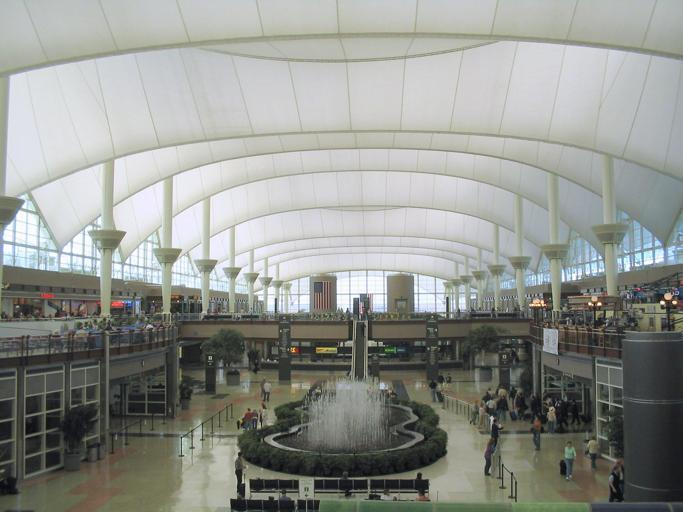

In [51]:
image = Image.open('/content/ADE20k_toy_dataset/images/training/ADE_train_00000001.jpg')
image

In [52]:
# prepare the image for the model
pixel_values = image_processor(image, return_tensors="pt").pixel_values.to(device)
print(pixel_values.shape)

torch.Size([1, 3, 512, 512])


In [53]:
import torch

# forward pass
with torch.no_grad():
  outputs = model(pixel_values=pixel_values)

In [54]:
# logits are of shape (batch_size, num_labels, height/4, width/4)
logits = outputs.logits.cpu()
print(logits.shape)

torch.Size([1, 150, 128, 128])


In [55]:
def ade_palette():
    """ADE20K palette that maps each class to RGB values."""
    return [[120, 120, 120], [180, 120, 120], [6, 230, 230], [80, 50, 50],
            [4, 200, 3], [120, 120, 80], [140, 140, 140], [204, 5, 255],
            [230, 230, 230], [4, 250, 7], [224, 5, 255], [235, 255, 7],
            [150, 5, 61], [120, 120, 70], [8, 255, 51], [255, 6, 82],
            [143, 255, 140], [204, 255, 4], [255, 51, 7], [204, 70, 3],
            [0, 102, 200], [61, 230, 250], [255, 6, 51], [11, 102, 255],
            [255, 7, 71], [255, 9, 224], [9, 7, 230], [220, 220, 220],
            [255, 9, 92], [112, 9, 255], [8, 255, 214], [7, 255, 224],
            [255, 184, 6], [10, 255, 71], [255, 41, 10], [7, 255, 255],
            [224, 255, 8], [102, 8, 255], [255, 61, 6], [255, 194, 7],
            [255, 122, 8], [0, 255, 20], [255, 8, 41], [255, 5, 153],
            [6, 51, 255], [235, 12, 255], [160, 150, 20], [0, 163, 255],
            [140, 140, 140], [250, 10, 15], [20, 255, 0], [31, 255, 0],
            [255, 31, 0], [255, 224, 0], [153, 255, 0], [0, 0, 255],
            [255, 71, 0], [0, 235, 255], [0, 173, 255], [31, 0, 255],
            [11, 200, 200], [255, 82, 0], [0, 255, 245], [0, 61, 255],
            [0, 255, 112], [0, 255, 133], [255, 0, 0], [255, 163, 0],
            [255, 102, 0], [194, 255, 0], [0, 143, 255], [51, 255, 0],
            [0, 82, 255], [0, 255, 41], [0, 255, 173], [10, 0, 255],
            [173, 255, 0], [0, 255, 153], [255, 92, 0], [255, 0, 255],
            [255, 0, 245], [255, 0, 102], [255, 173, 0], [255, 0, 20],
            [255, 184, 184], [0, 31, 255], [0, 255, 61], [0, 71, 255],
            [255, 0, 204], [0, 255, 194], [0, 255, 82], [0, 10, 255],
            [0, 112, 255], [51, 0, 255], [0, 194, 255], [0, 122, 255],
            [0, 255, 163], [255, 153, 0], [0, 255, 10], [255, 112, 0],
            [143, 255, 0], [82, 0, 255], [163, 255, 0], [255, 235, 0],
            [8, 184, 170], [133, 0, 255], [0, 255, 92], [184, 0, 255],
            [255, 0, 31], [0, 184, 255], [0, 214, 255], [255, 0, 112],
            [92, 255, 0], [0, 224, 255], [112, 224, 255], [70, 184, 160],
            [163, 0, 255], [153, 0, 255], [71, 255, 0], [255, 0, 163],
            [255, 204, 0], [255, 0, 143], [0, 255, 235], [133, 255, 0],
            [255, 0, 235], [245, 0, 255], [255, 0, 122], [255, 245, 0],
            [10, 190, 212], [214, 255, 0], [0, 204, 255], [20, 0, 255],
            [255, 255, 0], [0, 153, 255], [0, 41, 255], [0, 255, 204],
            [41, 0, 255], [41, 255, 0], [173, 0, 255], [0, 245, 255],
            [71, 0, 255], [122, 0, 255], [0, 255, 184], [0, 92, 255],
            [184, 255, 0], [0, 133, 255], [255, 214, 0], [25, 194, 194],
            [102, 255, 0], [92, 0, 255]]

In [57]:
predicted_segmentation_map = image_processor.post_process_semantic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
predicted_segmentation_map = predicted_segmentation_map.cpu().numpy()
print(predicted_segmentation_map)

[[5 5 5 ... 5 5 5]
 [5 5 5 ... 5 5 5]
 [5 5 5 ... 5 5 5]
 ...
 [3 3 3 ... 0 0 0]
 [3 3 3 ... 0 0 0]
 [3 3 3 ... 0 0 0]]


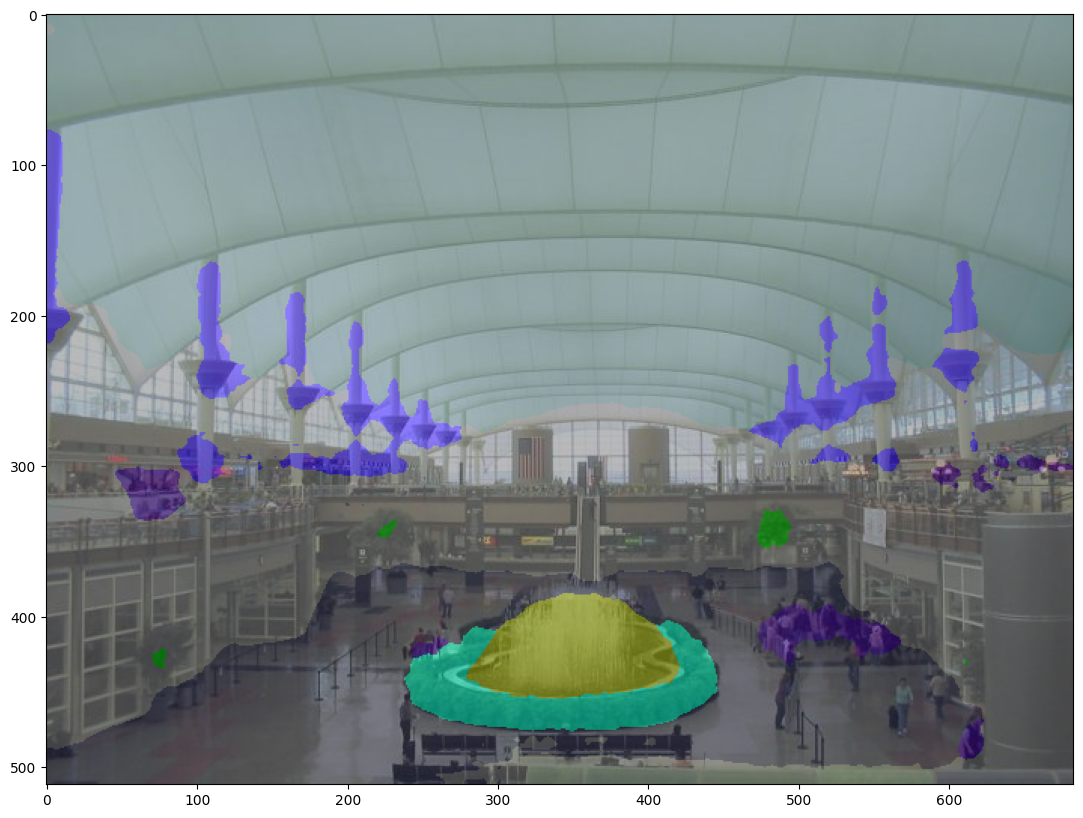

In [60]:
import matplotlib.pyplot as plt
import numpy as np

color_seg = np.zeros((predicted_segmentation_map.shape[0],
                      predicted_segmentation_map.shape[1], 3), dtype=np.uint8) # height, width, 3

palette = np.array(ade_palette())
for label, color in enumerate(palette):
    color_seg[predicted_segmentation_map == label, :] = color
# Convert to BGR
color_seg = color_seg[..., ::-1]

# Show image + mask
img = np.array(image) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

Compare this to the ground truth segmentation map:

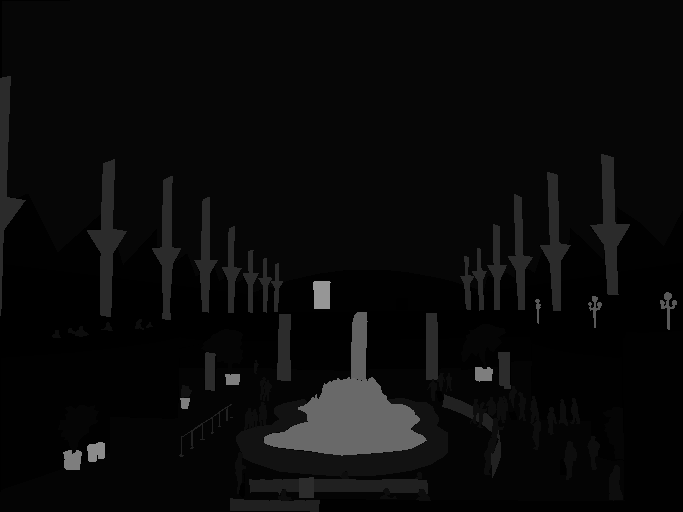

In [61]:
map = Image.open('/content/ADE20k_toy_dataset/annotations/training/ADE_train_00000001.png')
map

Classes in this image: ['wall', 'floor', 'tree', 'ceiling', 'person', 'plant', 'seat', 'fence', 'column', 'signboard', 'streetlight', 'escalator', 'fountain', 'pot', 'ashcan', 'flag', None]


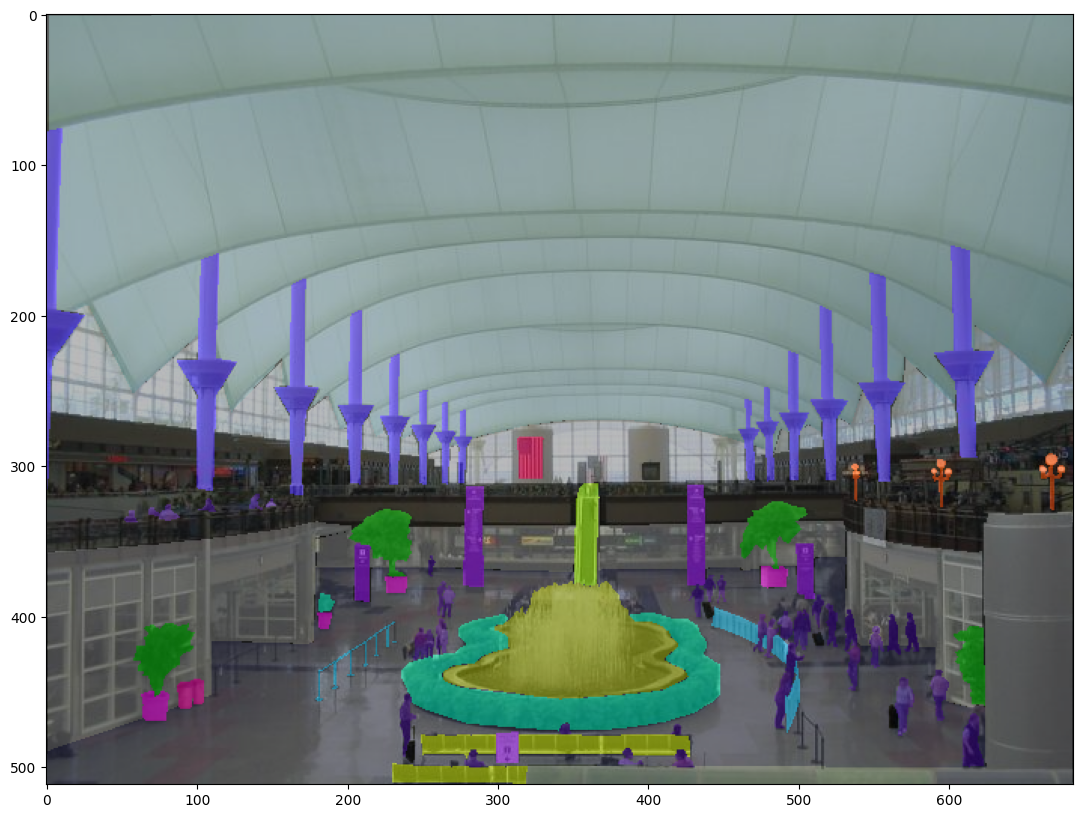

In [62]:
# convert map to NumPy array
map = np.array(map)
map[map == 0] = 255 # background class is replaced by ignore_index
map = map - 1 # other classes are reduced by one
map[map == 254] = 255

classes_map = np.unique(map).tolist()
unique_classes = [model.config.id2label[idx] if idx!=255 else None for idx in classes_map]
print("Classes in this image:", unique_classes)

# create coloured map
color_seg = np.zeros((map.shape[0], map.shape[1], 3), dtype=np.uint8) # height, width, 3
palette = np.array(ade_palette())
for label, color in enumerate(palette):
    color_seg[map == label, :] = color
# Convert to BGR
color_seg = color_seg[..., ::-1]

# Show image + mask
img = np.array(image) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

Let's compute the metrics:

In [ ]:
# metric expects a list of numpy arrays for both predictions and references
metrics = metric._compute(
                  predictions=[predicted_segmentation_map],
                  references=[map],
                  num_labels=len(id2label),
                  ignore_index=255,
                  reduce_labels=False, # we've already reduced the labels ourselves
              )

Exception ignored in: <function _xla_gc_callback at 0x78d202217880>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 97, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 
Exception ignored in: <function _xla_gc_callback at 0x78d202217880>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 97, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 
Exception ignored in: <function _xla_gc_callback at 0x78d202217880>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 97, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


In [ ]:
metrics.keys()

In [ ]:
import pandas as pd

# print overall metrics
for key in list(metrics.keys())[:3]:
  print(key, metrics[key])

# pretty-print per category metrics as Pandas DataFrame
metric_table = dict()
for id, label in id2label.items():
    metric_table[label] = [
                           metrics["per_category_iou"][id],
                           metrics["per_category_accuracy"][id]
    ]

print("---------------------")
print("per-category metrics:")
pd.DataFrame.from_dict(metric_table, orient="index", columns=["IoU", "accuracy"])